In [1]:
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER') or '/home/fne23_stjarnholm/master-project'}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt

results = []

result_folders = run_tools.get_all_result_dirs()

# Loop over each run number and get the run settings as well as the k-effective
for result_folder in result_folders:
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    results.append(result)

In [2]:
# PLOT SETTINGS:
FAST_REACTOR = False

def get_filename(plot_type: str, value: str):
    return f"{plot_type}_{value}-FAST_REACTOR={FAST_REACTOR}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filter for FAST_REACTOR
df = df[df["FAST_REACTOR"] == FAST_REACTOR]

if df.empty:
    raise Exception("No results found!")

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed
0,0.965636,0.037655,../results/RUNDATA_R2_1,False,100,10,50,1.675786e+09,1.675786e+09,5.452
1,1.001025,0.017151,../results/RUNDATA_R2_2,False,100,30,50,1.675786e+09,1.675786e+09,5.113
2,0.996800,0.008860,../results/RUNDATA_R2_3,False,100,100,50,1.675786e+09,1.675786e+09,5.804
3,0.986742,0.005139,../results/RUNDATA_R2_4,False,100,300,50,1.675786e+09,1.675786e+09,7.938
4,0.983465,0.002837,../results/RUNDATA_R2_5,False,100,1000,50,1.675786e+09,1.675786e+09,15.177


In [3]:
# pivot the dataframe from long to wide form
pivoted_df_k_eff = df.pivot(index='particle_count', columns='active_batch_count', values='k-eff')
pivoted_df_k_eff_std = df.pivot(index='particle_count', columns='active_batch_count', values='k-eff-std')
pivoted_df_t_elapsed = df.pivot(index='particle_count', columns='active_batch_count', values='t_elapsed')

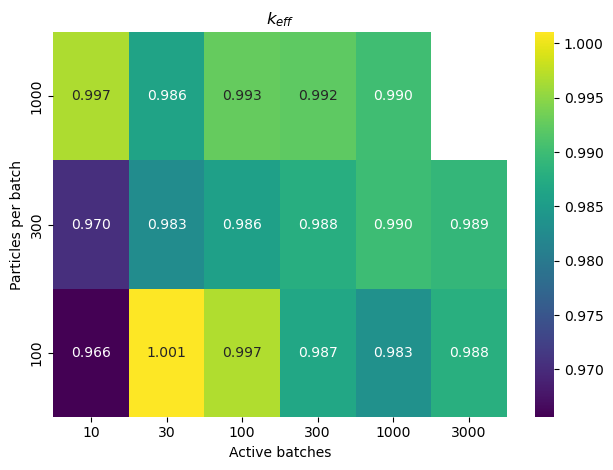

In [4]:
ax = sns.heatmap(pivoted_df_k_eff, annot=True, fmt=".3f", cmap='viridis')
ax.invert_yaxis()
plt.title("$k_{eff}$")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "k_eff"))

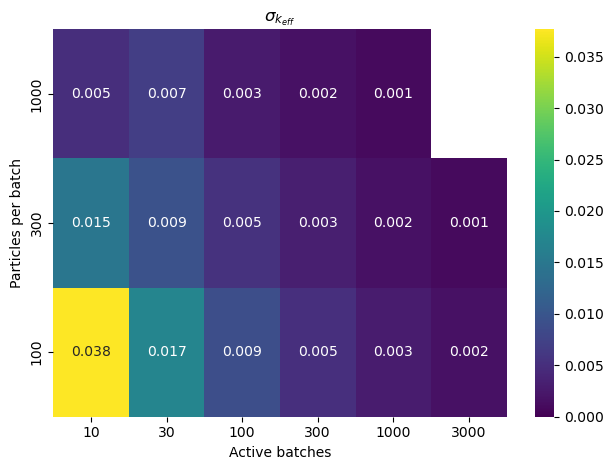

In [5]:
ax = sns.heatmap(pivoted_df_k_eff_std, annot=True, fmt=".3f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title("$\sigma_{k_{eff}}$")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "k_eff_std"))

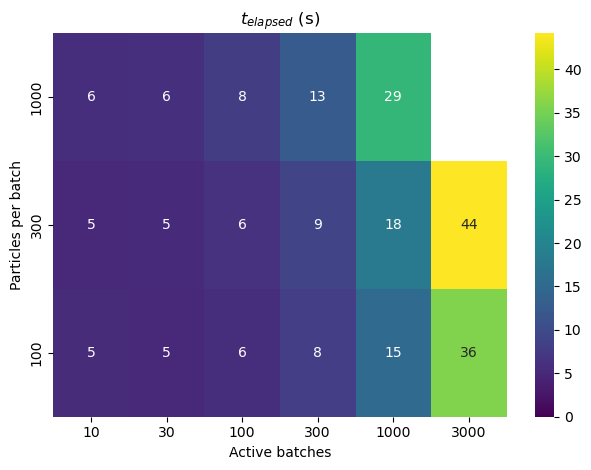

In [6]:
ax = sns.heatmap(pivoted_df_t_elapsed, annot=True, fmt=".0f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title("$t_{elapsed}$ (s)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "t_elapsed"))